## Multiclass classification of histopathological images of lung and colon tissue

<center>
  <img src="dataset-cover.jpeg" alt="Dataset cover" width="1000">
  <div style="font-size: smaller; font-style: italic;">
    Photo taken from Pixabay at Pexels
  </div>
</center>

Aim of this project is to distinguish **five classes**:
* Colon adenocarcinoma
* Colon benign tissue
* Lung adenocarcinoma
* Lung benign tissue
* Lung squamous cell carcinoma

The dataset utilized consists of lung and colon cancer **histopathological images**, containing 25,000 images. Each image is 768 x 768 pixels in *jpeg* file format. 
We will use **convolutional neural network** and Python with the `PyTorch` framework.


<center>
  <div style="display: flex; flex-direction: row; justify-content: center;">
    <div style="text-align: center; margin: 10px;">
      <img src="lung_colon_image_set\colon_image_sets\colon_aca\colonca1.jpeg" alt="colon aca" width="200">
      <div style="font-size: smaller; font-style: italic;">
      (1) colon adenocarcinoma</div>
    </div>
    <div style="text-align: center; margin: 10px;">
      <img src="lung_colon_image_set\colon_image_sets\colon_n\colonn1.jpeg" alt="colon n" width="200">
      <div style="font-size: smaller; font-style: italic;">
      (2) colon benign tissue</div>
    </div>
    <div style="text-align: center; margin: 10px;">
      <img src="lung_colon_image_set\lung_image_sets\lung_aca\lungaca1.jpeg" alt="lung aca" width="200">
      <div style="font-size: smaller; font-style: italic;">
      (3) lung adenocarcinoma</div>
    </div>
    <div style="text-align: center; margin: 10px;">
      <img src="lung_colon_image_set\lung_image_sets\lung_n\lungn1.jpeg" alt="lung n" width="200">
      <div style="font-size: smaller; font-style: italic;">
      (4) lung benign tissue</div>
    </div>
    <div style="text-align: center; margin: 10px;">
      <img src="lung_colon_image_set\lung_image_sets\lung_scc\lungscc1.jpeg" alt="lung scc" width="200">
      <div style="font-size: smaller; font-style: italic;">
      (5) lung squamous cell carcinoma</div>
    </div>
  </div>
</center>

### Importing libraries

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
from tqdm import tqdm

### Data preprocessing

In [40]:
# Define transforms
transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Load the dataset
dataset = datasets.ImageFolder("lung_colon_image_set", transform=transforms)

# Split the dataset into training and testing sets
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.1 * len(dataset))  # 10% for validation
test_size = len(dataset) - train_size - val_size  # 20% for testing
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Convolutional Neural Network Model

In [41]:
# Define the neural network
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),  # Output: 32x64x64
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),  # Output: 64x32x32
            nn.Flatten()
        )
        self.classifier = nn.Linear(64*32*32, num_classes)
    
    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

### Create the network

In [42]:
# Instantiate the network
net = Net(num_classes=5)
print(net)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

Net(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ELU(alpha=1.0)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Linear(in_features=65536, out_features=5, bias=True)
)


### Training loop

In [52]:
early_stopping_patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    # Validation loop
    net.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader.dataset)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve == early_stopping_patience:
        print("Early stopping")
        break

print("Finished Training")


Epoch 1/10: 100%|██████████| 274/274 [12:46<00:00,  2.80s/batch]


Epoch [1/10], Loss: 0.0179, Accuracy: 99.41%
Validation Loss: 0.0075, Validation Accuracy: 99.80%


Epoch 2/10: 100%|██████████| 274/274 [11:55<00:00,  2.61s/batch]


Epoch [2/10], Loss: 0.0230, Accuracy: 99.21%
Validation Loss: 0.0083, Validation Accuracy: 99.92%


Epoch 3/10: 100%|██████████| 274/274 [12:43<00:00,  2.79s/batch]


Epoch [3/10], Loss: 0.0084, Accuracy: 99.74%
Validation Loss: 0.0054, Validation Accuracy: 99.88%


Epoch 4/10: 100%|██████████| 274/274 [11:40<00:00,  2.56s/batch]


Epoch [4/10], Loss: 0.0075, Accuracy: 99.75%
Validation Loss: 0.0222, Validation Accuracy: 99.20%


Epoch 5/10: 100%|██████████| 274/274 [13:04<00:00,  2.86s/batch]


Epoch [5/10], Loss: 0.0069, Accuracy: 99.81%
Validation Loss: 0.0063, Validation Accuracy: 99.88%


Epoch 6/10: 100%|██████████| 274/274 [11:23<00:00,  2.49s/batch]


Epoch [6/10], Loss: 0.0031, Accuracy: 99.93%
Validation Loss: 0.0021, Validation Accuracy: 99.96%


Epoch 7/10: 100%|██████████| 274/274 [11:26<00:00,  2.51s/batch]


Epoch [7/10], Loss: 0.0034, Accuracy: 99.90%
Validation Loss: 0.0016, Validation Accuracy: 99.96%


Epoch 8/10: 100%|██████████| 274/274 [10:56<00:00,  2.40s/batch]


Epoch [8/10], Loss: 0.0027, Accuracy: 99.91%
Validation Loss: 0.0053, Validation Accuracy: 99.84%


Epoch 9/10: 100%|██████████| 274/274 [11:01<00:00,  2.41s/batch]


Epoch [9/10], Loss: 0.1422, Accuracy: 97.93%
Validation Loss: 0.0024, Validation Accuracy: 99.96%


Epoch 10/10: 100%|██████████| 274/274 [11:12<00:00,  2.46s/batch]


Epoch [10/10], Loss: 0.0016, Accuracy: 99.97%
Validation Loss: 0.0021, Validation Accuracy: 99.96%
Finished Training


### Evaluation on the test set

In [54]:
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set: {100 * correct / total:.2f}%')

Accuracy on the test set: 99.80%


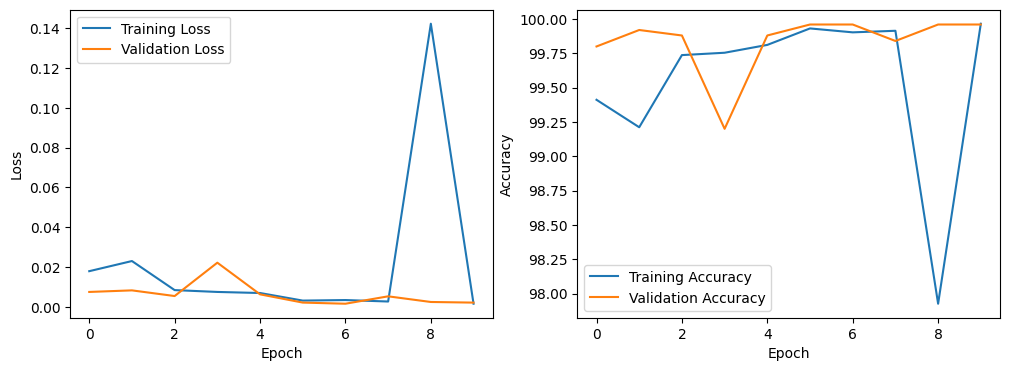

In [53]:
# Plotting the training and validation losses and accuracies
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [1]:
import torch
from torchvision import datasets, transforms
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Definicja transformacji
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Zmniejszenie rozmiaru obrazów
    transforms.ToTensor()
])

# Wczytanie danych
dataset = datasets.ImageFolder("lung_colon_image_set", transform=transform)

# Podział danych na zbiory treningowy i testowy
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Przekształcenie danych partiami
def batch_data_loader(dataset):
    data = []
    labels = []
    for img, label in dataset:
        img = img.view(-1).numpy()  # Spłaszczenie obrazów do wektora
        data.append(img)
        labels.append(label)
    return np.array(data), np.array(labels)

# Przekształć dane treningowe
X_train, y_train = batch_data_loader(train_dataset)
# Przekształć dane testowe
X_test, y_test = batch_data_loader(test_dataset)

# Normalizacja danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Definicja i trenowanie modelu SVM
svm_model = SVC(kernel='linear', C=1)
svm_model.fit(X_train, y_train)

# Predykcja na zbiorze testowym
y_pred = svm_model.predict(X_test)

# Ocena modelu
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on the test set: {accuracy * 100:.2f}%')



Accuracy on the test set: 93.64%
